In [1]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('features.csv')

# Drop columns not needed
drop_cols = ['Round','Date','Score','Year','winner','Host','home_points','away_points']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

print("✅ Loaded dataset with shape:", df.shape)
df.head()


✅ Loaded dataset with shape: (241, 11)


,home_team,away_team,home_score,away_score,result_numeric,home_rank,away_rank,rank_diff,home_elo,away_elo,elo_diff
0,Argentina,France,3,3,0,1,2,-1,1867.25,1859.78,7.47
1,Croatia,Morocco,2,1,1,13,14,-1,1691.59,1688.18,3.41
2,France,Morocco,2,0,1,2,14,-12,1859.78,1688.18,171.60
3,Argentina,Croatia,3,0,1,1,13,-12,1867.25,1691.59,175.66
4,Morocco,Portugal,1,0,1,14,6,8,1688.18,1756.12,-67.94


In [2]:
# Create home and away result tables
home_results = df[['home_team', 'result_numeric']].copy()
home_results.rename(columns={'home_team':'team'}, inplace=True)
home_results['result'] = home_results['result_numeric'].map({1:1, 0:0.5, -1:0})  # draw=0.5, win=1, loss=0

away_results = df[['away_team', 'result_numeric']].copy()
away_results.rename(columns={'away_team':'team'}, inplace=True)
away_results['result'] = away_results['result_numeric'].map({-1:1, 0:0.5, 1:0})  # reverse for away team

# Combine home & away into one performance table
team_results = pd.concat([home_results, away_results])
team_results = team_results.sort_index().reset_index(drop=True)
print("✅ Created team_results table:", team_results.shape)
team_results.head(10)


✅ Created team_results table: (482, 3)


,team,result_numeric,result
0,Argentina,0,0.5
1,France,0,0.5
2,Morocco,1,0.0
3,Croatia,1,1.0
4,Morocco,1,0.0
5,France,1,1.0
6,Argentina,1,1.0
7,Croatia,1,0.0
8,Portugal,1,0.0
9,Morocco,1,1.0


In [3]:
# Overall win rate
overall_form = team_results.groupby('team')['result'].mean().reset_index()
overall_form.rename(columns={'result': 'overall_win_rate'}, inplace=True)

# Rolling win rate (last 10 matches)
team_results['rolling_win_rate'] = team_results.groupby('team')['result'].transform(
    lambda x: x.rolling(window=10, min_periods=1).mean()
)

# Latest rolling win rate per team (most recent entry)
latest_form = team_results.groupby('team')['rolling_win_rate'].last().reset_index()
latest_form.rename(columns={'rolling_win_rate': 'last10_win_rate'}, inplace=True)

# Merge both together
form_df = overall_form.merge(latest_form, on='team', how='outer')

print("✅ Calculated overall and rolling win rates:", form_df.shape)
form_df.head()


✅ Calculated overall and rolling win rates: (40, 3)


,team,overall_win_rate,last10_win_rate
0,Algeria,0.400000,0.40
1,Argentina,0.703704,0.75
2,Australia,0.285714,0.30
3,Belgium,0.687500,0.75
4,Brazil,0.720000,0.90


In [4]:
# Merge home team form
df = df.merge(form_df, left_on='home_team', right_on='team', how='left')
df.rename(columns={
    'overall_win_rate': 'home_overall_win_rate',
    'last10_win_rate': 'home_last10_win_rate'
}, inplace=True)
df.drop(columns=['team'], inplace=True)

# Merge away team form
df = df.merge(form_df, left_on='away_team', right_on='team', how='left')
df.rename(columns={
    'overall_win_rate': 'away_overall_win_rate',
    'last10_win_rate': 'away_last10_win_rate'
}, inplace=True)
df.drop(columns=['team'], inplace=True)

print("✅ Added win rate features!")
df.head()


✅ Added win rate features!


,home_team,away_team,home_score,away_score,result_numeric,home_rank,away_rank,rank_diff,home_elo,away_elo,elo_diff,home_overall_win_rate,home_last10_win_rate,away_overall_win_rate,away_last10_win_rate
0,Argentina,France,3,3,0,1,2,-1,1867.25,1859.78,7.47,0.703704,0.75,0.714286,0.55
1,Croatia,Morocco,2,1,1,13,14,-1,1691.59,1688.18,3.41,0.476190,0.40,0.450000,0.45
2,France,Morocco,2,0,1,2,14,-12,1859.78,1688.18,171.60,0.714286,0.55,0.450000,0.45
3,Argentina,Croatia,3,0,1,1,13,-12,1867.25,1691.59,175.66,0.703704,0.75,0.476190,0.40
4,Morocco,Portugal,1,0,1,14,6,8,1688.18,1756.12,-67.94,0.450000,0.45,0.475000,0.55


In [5]:
# Remove draws for training
df = df[df['result_numeric'] != 0].reset_index(drop=True)

# Target variable
y = df['result_numeric'].values  # -1 = away win, 1 = home win

# Feature columns
features = [
    'home_rank','away_rank','rank_diff',
    'home_elo','away_elo','elo_diff',
    'home_overall_win_rate','away_overall_win_rate',
    'home_last10_win_rate','away_last10_win_rate'
]

X = df[features].values
print("✅ Final feature set size:", X.shape)


✅ Final feature set size: (188, 10)


✅ Binary Random Forest Accuracy: 0.632
Macro F1 Score: 0.650

Classification Report:
               precision    recall  f1-score   support

away_win(-1)       0.55      0.69      0.61        16
 home_win(1)       0.72      0.59      0.65        22

    accuracy                           0.63        38
   macro avg       0.64      0.64      0.63        38
weighted avg       0.65      0.63      0.63        38



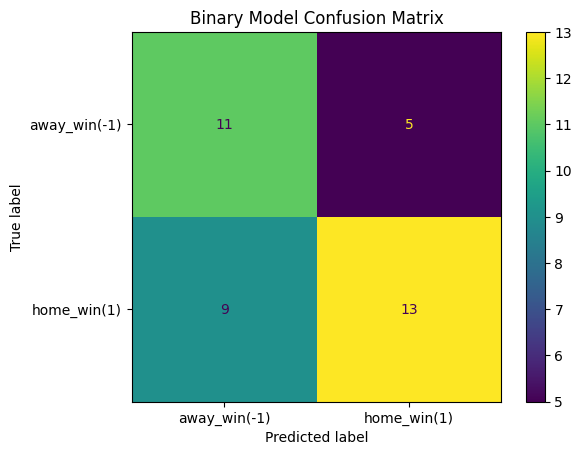

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Model pipeline (scaler optional but helps)
model = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1))
])

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"✅ Binary Random Forest Accuracy: {acc:.3f}")
print(f"Macro F1 Score: {f1:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['away_win(-1)','home_win(1)']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[-1,1])
disp = ConfusionMatrixDisplay(cm, display_labels=['away_win(-1)','home_win(1)'])
disp.plot(values_format='d')
plt.title('Binary Model Confusion Matrix')
plt.show()


🎯 Random Forest Feature Importances:

away_overall_win_rate    0.162702
rank_diff                0.147366
elo_diff                 0.142342
away_last10_win_rate     0.090201
home_overall_win_rate    0.086104
away_rank                0.083119
away_elo                 0.080710
home_last10_win_rate     0.074697
home_elo                 0.066814
home_rank                0.065944
dtype: float64


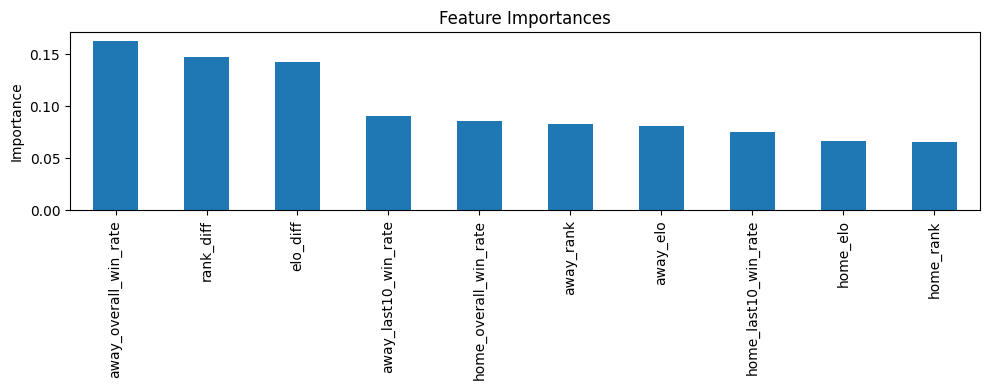

In [7]:
rf = model.named_steps['rf']
feat_imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

print("🎯 Random Forest Feature Importances:\n")
print(feat_imp)

feat_imp.plot(kind='bar', figsize=(10,4), title='Feature Importances')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
# Define parameter grid for tuning
param_grid = {
    'rf__n_estimators': [200, 500, 800],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2']
}

# Create pipeline (scaling + RF)
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Grid Search with 5-fold CV
grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Run search
grid_search.fit(X_train, y_train)

print("✅ Best Parameters Found:")
print(grid_search.best_params_)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
✅ Best Parameters Found:
{'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
Best CV Accuracy: 0.7533


🎯 Tuned RF Accuracy: 0.6316
Macro F1: 0.6818

              precision    recall  f1-score   support

away_win(-1)       0.56      0.56      0.56        16
 home_win(1)       0.68      0.68      0.68        22

    accuracy                           0.63        38
   macro avg       0.62      0.62      0.62        38
weighted avg       0.63      0.63      0.63        38



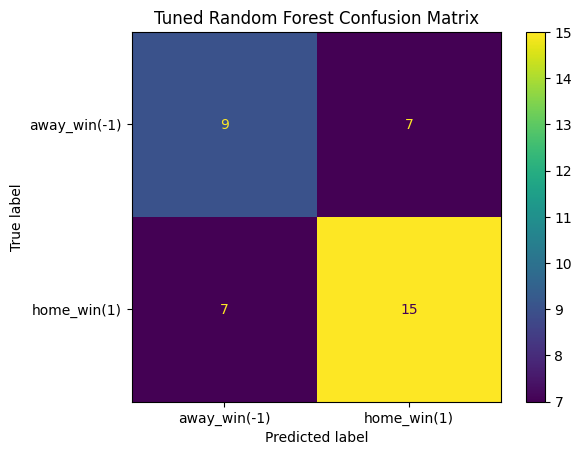

In [10]:
best_model = grid_search.best_estimator_

# Predict
y_pred = best_model.predict(X_test)

# Evaluate
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"🎯 Tuned RF Accuracy: {acc:.4f}")
print(f"Macro F1: {f1:.4f}\n")
print(classification_report(y_test, y_pred, target_names=['away_win(-1)','home_win(1)']))

cm = confusion_matrix(y_test, y_pred, labels=[-1,1])
disp = ConfusionMatrixDisplay(cm, display_labels=['away_win(-1)','home_win(1)'])
disp.plot(values_format='d')
plt.title('Tuned Random Forest Confusion Matrix')
plt.show()


🚀 Tuned Random Forest Feature Importances:

away_overall_win_rate    0.203799
elo_diff                 0.152083
rank_diff                0.143988
away_last10_win_rate     0.094227
home_overall_win_rate    0.082912
away_rank                0.077497
home_last10_win_rate     0.076474
away_elo                 0.064897
home_rank                0.058456
home_elo                 0.045668
dtype: float64


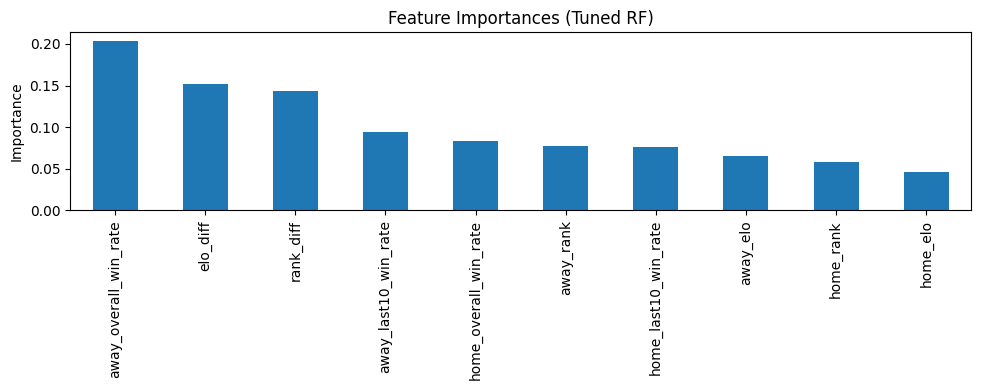

In [11]:
rf_best = best_model.named_steps['rf']
feat_imp = pd.Series(rf_best.feature_importances_, index=features).sort_values(ascending=False)

print("🚀 Tuned Random Forest Feature Importances:\n")
print(feat_imp)

feat_imp.plot(kind='bar', figsize=(10,4), title='Feature Importances (Tuned RF)')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()
